In [1]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import pdb 
import time
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import warnings

In [2]:
# with open("datasets/eth/train/students001_train.txt", 'r') as f:
#     for line in f:
#         line_data = [int(float(data)) if i < 2 else float(data) for i, data in enumerate(line.rsplit())]
#         print(line_data)

In [3]:
class FramesDataset(Dataset):
    def text2Tensor(self, file_data):
        #process the file data such that it's a list of lists of offset tuple in each time step
        file_data_t = []
        data_temp = []
        try:
            frame_num = file_data[0][0]
        except IndexError:
            print("???:")
            print(file_data)
        traj_list = []
        frame_list = []
        for line in file_data:
            if frame_num != line[0]:
                frame_num = line[0]
                data_temp.sort(key=lambda data : data[1])
                file_data_t.append(data_temp)
                data_temp = [line]
            else:    
                data_temp.append(line)
            #keep a traj list for all trajs
            if line[1] not in traj_list:
                traj_list.append(line[1])
            if line[0] not in frame_list:
                frame_list.append(line[0])
        traj_list.sort()
        frame_list.sort()  
        
        #get participants in each frame
        #@note here the elements are ped's index in the traj list
        participants = [[] for i in range(len(file_data_t))]
        for frame_idx, line in enumerate(file_data_t):
            for traj_idx, traj in enumerate(traj_list):
                in_flag = False
                for data in line:
                    if data[1] == traj:
                        in_flag = True
                        participants[frame_idx].append(traj_list.index(data[1]))
                if not in_flag:
                    file_data_t[frame_idx].append([frame_list[frame_idx], traj, 0., 0.])
            file_data_t[frame_idx].sort(key=lambda data : data[1])

        file_data_tensors = torch.tensor(file_data_t, device=device)
        
        participant_masks = []
        for frame_idx, line in enumerate(participants):
            participant_masks.append([[torch.tensor(1.) if i in participants[frame_idx] else torch.tensor(0.) for i in range(len(traj_list))]])
        participant_masks = torch.tensor(participant_masks, device=device)
        
        return traj_list, participant_masks, file_data_tensors              
    
    
    '''
    @func preprocess
    @param path: relative path for the raw data
    @note raw data~ col1: frame index, col2: traj index, (col3, col4): (y, x)
    @return traj_list: indices for each trajactory in raw data
            participants_masks~tensor(frame num x traj num): indicate the presence of each ped at each frame
            file_data_tensors~tensor(frame num x traj num x 4): the position of each traj at each frame
                                                                if not present default to (0,0)
    '''
    def preprocess(self, path):
        #open the file as it is
        file_data = []
        with open(path, 'r') as file:
            for line in file:
                line_data = [int(float(data)) if i < 2 else float(data) for i, data in enumerate(line.rsplit())]
                line_data[2], line_data[3] = line_data[3], line_data[2]
                file_data.append(line_data)
        file_data = sorted(file_data, key=lambda data : data[1])
        file_data_sort = sorted(file_data, key=lambda data : data[0])
        
        traj_list, participant_masks, coord_tensors = self.text2Tensor(file_data_sort)
        
        #process the file data such that it contains the offsets not global coords
        file_data_off = []
        for i, line in enumerate(file_data):
            if i > 0:
                if file_data[i][1] == file_data[i-1][1]:
                    file_data_off.append([file_data[i][0], file_data[i][1], file_data[i][2]-file_data[i-1][2], file_data[i][3]-file_data[i-1][3]])
        file_data_off.sort(key=lambda data : data[0])        
        
        traj_list, participant_masks, off_tensors = self.text2Tensor(file_data_off)
        
        return traj_list, participant_masks, off_tensors, coord_tensors
    

    def __init__(self, path):
        self.traj_list, self.participant_masks, self.off_data, self.coord_data = self.preprocess(path)
        

    def __len__(self):
        return len(self.off_data)
    

    '''
    @note (X, Y) is a (file_data[idx], frame[idx+1]) pair if a single idx is provided
    a (frame[idx.start]2frame[idx.end], frame[idx.start+1]2frame[idx.end+1]) pair is provided
    if a index slice is provided
    the accompanying mask tensor follows the same rule 
    '''
    def __getitem__(self, idx):
        participant_mask = self.participant_masks[idx]
        X = self.off_data[idx]
        Z = torch.zeros(*X.shape)
        for coords in self.coord_data:
            if coords[0][0] == X[0][0]:
                Z = coords
        ret_data = {}
        ret_data["seq"] = X
        ret_data["mask"] = participant_mask
        ret_data["idx"] = idx
        ret_data["coords"] = Z
        return ret_data

    
    def getTrajList(self):
        return self.traj_list

    
    def getParticipants(self):
        return self.participant_mask
    
    
    def getCoordinates(self, seq):
        #get the coord data at the time step right before the seq starts
        before_coords = torch.empty(len(self.traj_list), 4, device=device)
        for x in seq:
            for i, coords in enumerate(self.coord_data):
                if coords[0][0] == x[0][0]:
                    before_coords = self.coord_data[i-1]
                    break
            break
        ret_data = torch.reshape(before_coords, (1, before_coords.shape[0], before_coords.shape[1])) 
        #get the rest
        for i, x in enumerate(seq):
            for j, coords in enumerate(self.coord_data):
                if coords[0][0] == x[0][0]:
                    coords_reshaped = torch.reshape(coords.clone(), (1, before_coords.shape[0], before_coords.shape[1]))                     
                    ret_data = torch.cat((ret_data, coords_reshaped), 0)
                    break
        return ret_data
    
    
    
    
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# D = FramesDataset("try_dataset.txt")
# Dloader = DataLoader(D, batch_size=20)

# for i, data in enumerate(Dloader):
#     if i == 0:
#         print(f"idx {data['idx']}")
#         print(f"X {data['seq'].shape}\n")
#         for i in data['seq']:
#             print(i)
#         print(f"mask\n {data['mask']}")
#         print(f"coords {data['coords'].shape}\n")   
#         for i in data['coords']:
#             print(i)       
#         print("\n\n\n\ntemp \n\n")
#         temp = D.getCoordinates(data['seq'])
#         for i in temp:
#             print(i)

In [4]:
class Phi(nn.Module):
    ''' a non-linear layer'''
    def __init__(self, dropout_prob):
        super(Phi, self).__init__()
        self.dropout_prob = dropout_prob
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        return self.Dropout(self.ReLU(x))


class VanillaLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, mediate_dim=10, output_dim=2, traj_num=3, dropout_prob=0.2):
        super(VanillaLSTM, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.traj_num = traj_num
        self.InputLayer = nn.Linear(input_dim, mediate_dim)
        self.LSTMCell = nn.LSTMCell(mediate_dim, hidden_dim)
        self.OutputLayer = nn.Linear(hidden_dim, output_dim)
        self.Phi = Phi(dropout_prob=dropout_prob)


    def forward(self, X, part_masks, all_h_t, all_c_t, Y, T_obs, T_pred):
        outputs = torch.empty(X.shape[0], X.shape[1], self.output_dim, device=device)
        for frame_idx, x in enumerate(X):      
            if frame_idx <= T_obs or frame_idx > T_pred:
                outputs[frame_idx] = torch.zeros(X.shape[1], self.output_dim)
                continue

            r = self.Phi(self.InputLayer(x[:,2:]))
            all_h_t, all_c_t = self.LSTMCell(r, (all_h_t, all_c_t))
            part_mask = torch.t(part_masks[frame_idx]).expand(part_masks[frame_idx].shape[1], self.output_dim)
            outputs[frame_idx] = self.OutputLayer(all_h_t) * part_mask

            #dirty fix for appearance that's too short
            if frame_idx > 3 and frame_idx > T_obs:
                for traj_idx in torch.where(part_masks[frame_idx][0] != 0)[0]:
                    if part_masks[frame_idx-3][0][traj_idx] == 0:
                        outputs[frame_idx, traj_idx] = Y[frame_idx, traj_idx] 

        return outputs

In [5]:
def train(T_obs, T_pred, file, model=None):
    tic = time.time()
    print(f"training on {file}")    
    
    h_dim = 128
    batch_size = T_pred

    #try to train this
#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset(file)
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)

    if model == None:
        print("instantiating model")
        vl = VanillaLSTM(hidden_dim=h_dim, mediate_dim=128, output_dim=2, traj_num=traj_num)
    else:
        vl = model
    vl.to(device)

    #define loss & optimizer
    criterion = nn.MSELoss(reduction="sum")
    # criterion = Gaussian2DNll
    optimizer = torch.optim.Adagrad(vl.parameters(), weight_decay=0.0005)

    plot_data = [[] for _ in range(len(dataset) // batch_size)]
    #sequentially go over the dataset batch_size by batch_size
    EPOCH = 10
    for epoch in range(EPOCH):
        print(f"epoch {epoch+1}/{EPOCH}  ")
        for batch_idx, data in enumerate(dataloader):
            print(f"batch {batch_idx+1}/{len(dataset) // batch_size} ", end='\r')
            if batch_idx < len(dataset) // batch_size:
                Y = data['seq'][:T_pred][:T_pred,:,2:].clone()
                input_seq = data['seq'][:T_pred].clone()
                part_masks = data['mask']
                with torch.autograd.set_detect_anomaly(True):         
                    #forward prop
                    output = vl(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                    #compute loss
                    Y_pred = output[T_obs+1:T_pred]
                    Y_g = Y[T_obs+1:T_pred]

                    cost = criterion(Y_pred, Y_g)

                    if epoch % 10 == 9:
                        print(epoch, batch_idx, cost.item())

                    #save data for plotting
                    plot_data[batch_idx].append(cost.item())

                    #backward prop
                    optimizer.zero_grad()
                    cost.backward()
                    optimizer.step()

    toc = time.time()
    print(f"training consumed {toc-tic}")

    #plot the cost
    plt.figure()
    for data in plot_data:
        plt.plot(np.arange(len(plot_data[0])), data)
    
    #save the model
    torch.save(vl, "vl.pt")
    print("saved model in vl.pt\n")    

    return vl

In [6]:
def trajTruncate(coords, Y, part_mask, ratio=0.6):
    #count appearance
    for traj in range(coords.shape[1]):
        count = 0
        for t in range(part_mask.shape[0]):
            if part_mask[t][0][traj] != 0:
                count += 1
        if count < part_mask.shape[0]*ratio:
#             for t in range(coords.shape[0]):
#                 coords[t][traj][2:] *= 0.
            for t in range(Y.shape[0]):
                Y[t][traj] *= 0.
    
    return coords, Y

In [7]:
def validate(model, T_obs, T_pred, file):
    #try to validate this
    h_dim = 128

    batch_size = T_pred

#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset(file)    
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)
    
    plotting_batches = np.arange(10)
    plotting_data = []
    avgDispErrMeans = []
    finalDispErrMeans = []    
    #validate the model based on the dataset
    print(f"validating on {file}")
    for batch_idx, data in enumerate(dataloader):
        if batch_idx < len(dataset) // batch_size:
            Y = data['seq'][:T_pred,:,2:].clone()
            input_seq = data['seq'][:T_pred].clone()
            part_masks = data['mask']            
            with torch.autograd.set_detect_anomaly(True):         
                print(f"batch {batch_idx+1}/{len(dataset) // batch_size}  ", end='\r')
                #forward prop
                output = model(input_seq, part_masks, h, c, Y, T_obs, T_pred)

                #compute cost
                Y_pred = output[T_obs+1:T_pred]
                Y_g = Y[T_obs+1:T_pred]
                #......

                #get and process result                
                Y_g_param = Y_pred.clone()
                coords_param = dataset.getCoordinates(data['seq']).clone()
#                 print(f"shapess {Y_g_param.shape} {coords_param.shape}")
                
                #dirty truncate
                coords_param, Y_pred = trajTruncate(coords_param, Y_pred, part_masks, ratio=0.6)
#                 print(f"shapessss {Y_g_param.shape} {coords_param.shape}")
                
                
#                 dists_list = [np.array([]) for _ in range(traj_num)]
#                 batch_parts = []
#                 for frame_idx, (y_pred, y_g) in enumerate(zip(Y_pred, Y_g)):
#                     for traj_idx in range(part_masks[frame_idx].shape[1]):
#                         if part_masks[frame_idx+T_obs+1][0][traj_idx] != 0:
#                             if traj_idx not in batch_parts:
#                                 batch_parts.append(traj_idx)
#                             dist = torch.dist(y_pred[traj_idx],y_g[traj_idx]).item()
#                             print(f"at frame {frame_idx+T_obs+1} ped {traj_idx} is off by {dist}\n")
#                             dists_list[traj_idx] = np.append(dists_list[traj_idx], dist)
                
#                 total_ADE = np.array([])
#                 total_FDE = np.array([])
#                 for batch_part in batch_parts:
#                     ADE = np.average(dists_list[batch_part])
#                     print(f"ADE of traj {batch_part} {ADE}")
#                     total_ADE = np.append(total_ADE, ADE)
#                     print(f"FDE of traj {batch_part} {dists_list[batch_part][-1]}")
#                     total_FDE = np.append(total_FDE, dists_list[batch_part][-1])
#                     print("------------------------------------------------------")

#                 print(f"total ADE {np.average(total_ADE)}")
#                 print(f"total FDE {np.average(total_FDE)}")
#                 print("================================================================")

                
                #save plotting data for visualization
                if batch_idx in plotting_batches:
                    plotting_data.append((Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs))
                    
                if batch_idx in range(len(dataset) // batch_size-1):
                    err = avgDispError(Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs)
                    avgDispErrMeans.append(err)
                    
                if batch_idx in range(len(dataset) // batch_size-1):
                    err = finalDispError(Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs)
                    finalDispErrMeans.append(err)                
        
    for d in plotting_data:
        plotting_batch(*d)
        
    print("total avg disp mean ", np.mean(np.array(avgDispErrMeans)))
    print("total final disp mean ", np.mean(np.array(finalDispErrMeans)))    

In [8]:
'''
@param trajs~(frame_num of a batch x traj_num x 2)
'''
def plotting_batch(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):          
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step for plotting
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)
        
    #plot
    plt.figure(figsize=(12,12))
    plot_idx = 0
    for traj_idx in parts:
        try:
            pred_x = trajs_pred_coords[traj_idx][:,0]
        except IndexError:
            print("not enough appearance")
            continue
        pred_y = trajs_pred_coords[traj_idx][:,1]            
        plt.plot(pred_x, pred_y, label="pred"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(pred_x, pred_y)):
            if i < len(pred_x)-1:
                plt.arrow(x, y, (pred_x[i+1] - x)/2, (pred_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)            

        total_x = batch_coords[:,traj_idx,2]        
        total_x = total_x[np.where(total_x != 0.)]
        total_y = batch_coords[:,traj_idx,3]
        total_y = total_y[np.where(total_y != 0.)]        
        plt.plot(total_x, total_y, linestyle="dashed", label="total"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(total_x, total_y)):
            if i < len(total_x)-1:
                plt.arrow(x, y, (total_x[i+1] - x)/2, (total_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)
        plot_idx += 1
 
    plt.legend(loc="upper right")
    plt.title(f"batch {batch_idx}")
    
    
def avgDispError(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)   
        
    
    #compare
    trajs_dist = []
    step_num = 0
    for traj_idx, traj in enumerate(parts):
        T_valid = T_obs+1+trajs_pred_coords[traj].shape[0]
        diff = batch_coords[T_obs+1:T_valid,traj,2:] - trajs_pred_coords[traj]
        traj_dist = np.sum(np.linalg.norm(diff, axis=1))        
        if not math.isnan(traj_dist):
            trajs_dist.append(traj_dist)
            step_num += diff.shape[0]

    if len(trajs_dist) != 0:
        mean_of_trajs_mean = np.sum(np.array(trajs_dist))/step_num
    else:
        mean_of_trajs_mean = 0
 
    print(f"avgDispError {mean_of_trajs_mean}")
    return mean_of_trajs_mean


def finalDispError(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)   
        
    
    #compare
    trajs_dist = []
    for traj_idx, traj in enumerate(parts):
        T_valid = T_obs+1+trajs_pred_coords[traj].shape[0]
        diff = batch_coords[T_obs+1:T_valid,traj,2:] - trajs_pred_coords[traj]
        final_diff = diff[-1]
        traj_dist = np.linalg.norm(final_diff)       
        if not math.isnan(traj_dist):
            trajs_dist.append(traj_dist)

    if len(trajs_dist) != 0:
        mean_of_trajs_final = np.mean(np.array(trajs_dist))
    else:
        mean_of_trajs_final = 0
 
    print(f"finalDispError {mean_of_trajs_final}")
    return mean_of_trajs_final

device cuda:0

training on datasets/zara1/train/crowds_zara02_train.txt
instantiating model
epoch 1/10
epoch 2/101 
epoch 3/101 
epoch 4/101 
epoch 5/101 
epoch 6/101 
epoch 7/101 
epoch 8/101 
epoch 9/101 
epoch 10/10 
9 0 0.07278299331665039
9 1 0.15833568572998047
9 2 0.22110307216644287
9 3 0.16663119196891785
9 4 0.06889910250902176
9 5 0.028636949136853218
9 6 0.2669234871864319
9 7 0.2432660311460495
9 8 0.18113112449645996
9 9 0.11776390671730042
9 10 0.18523015081882477
9 11 0.2211829423904419
9 12 0.17715173959732056
9 13 0.13558274507522583
9 14 0.09431909024715424
9 15 0.13811317086219788
9 16 0.21014776825904846
9 17 0.09406518936157227
9 18 0.022675443440675735
9 19 0.06629474461078644
9 20 0.10325919091701508
9 21 0.12343324720859528
9 22 0.21739298105239868
9 23 0.1752939224243164
9 24 0.4092813730239868
9 25 0.36645185947418213
9 26 0.23982958495616913
9 27 0.3133739233016968
9 28 0.3034595251083374
9 29 0.18257290124893188
9 30 0.154475137591362
9 31 0.186958104372024

ValueError: x and y must have same first dimension, but have shapes (13,) and (14,)

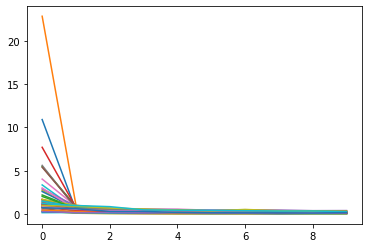

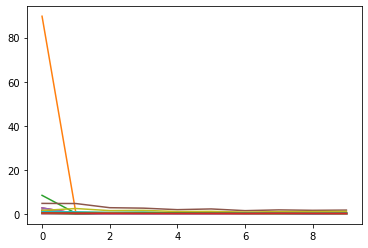

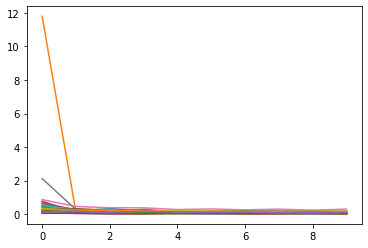

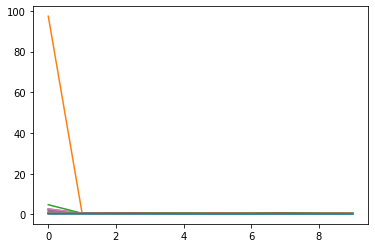

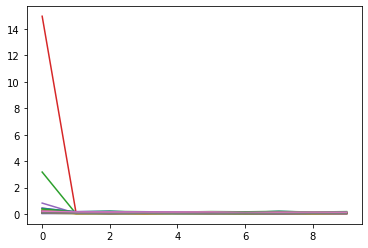

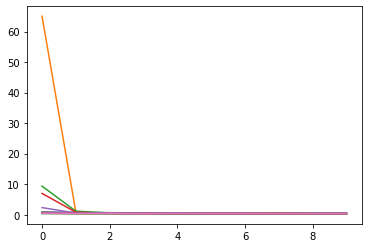

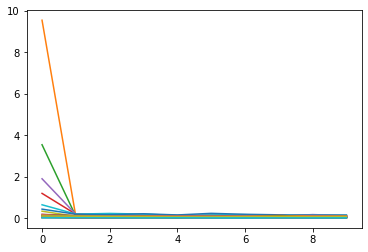

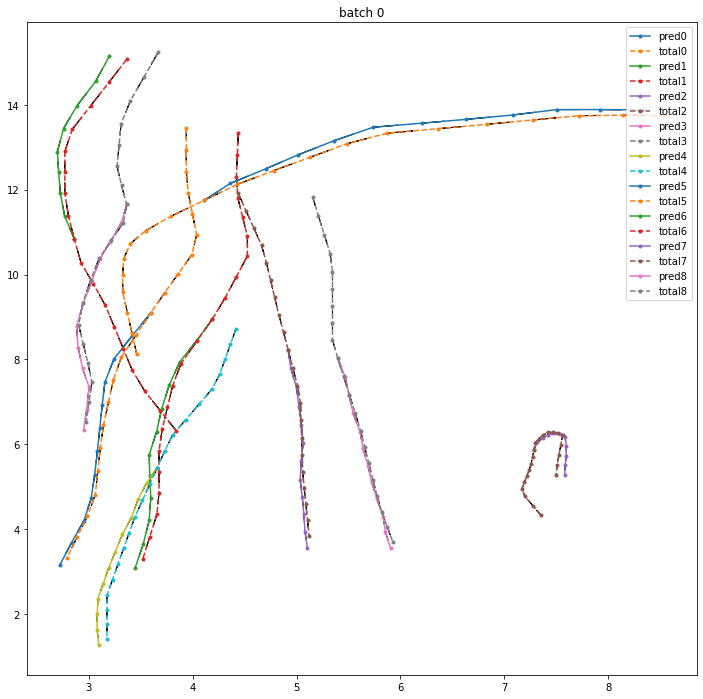

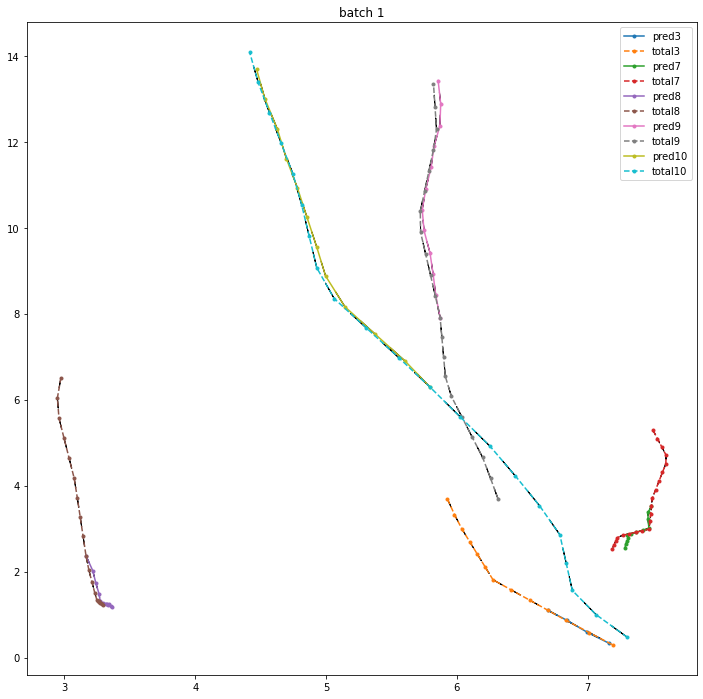

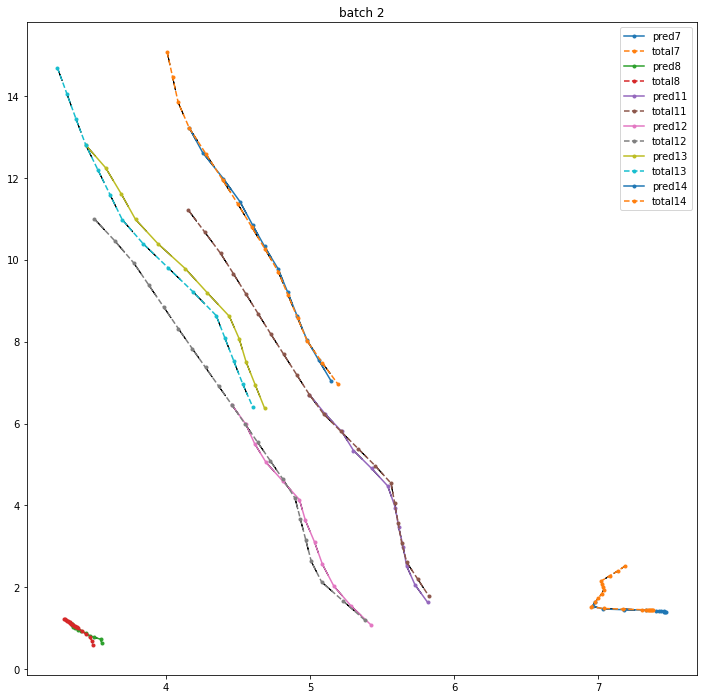

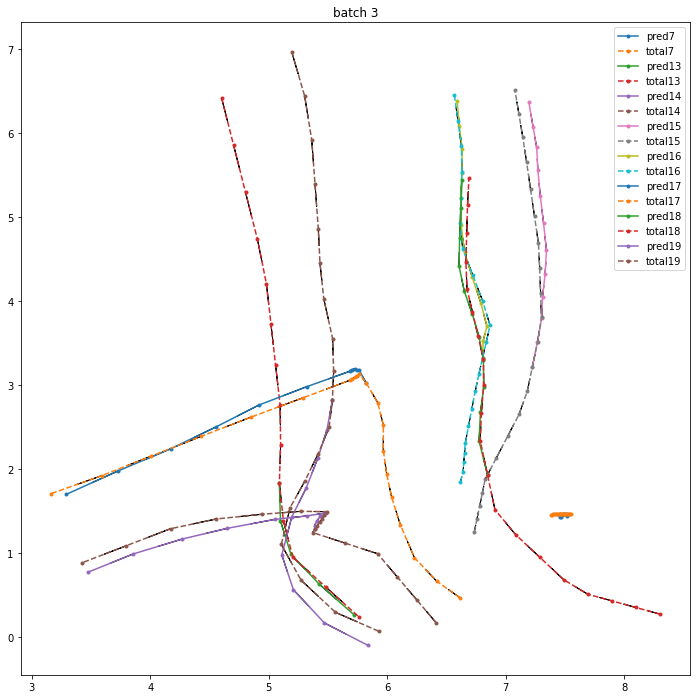

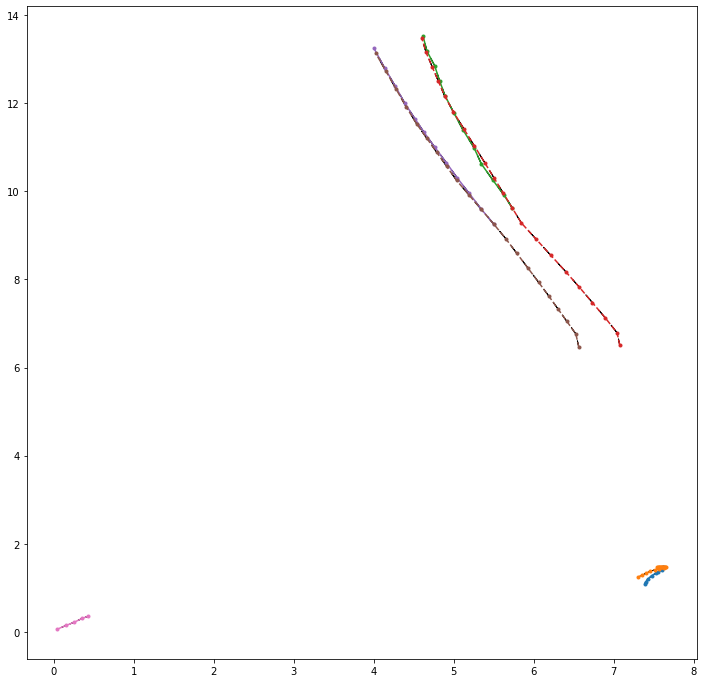

In [9]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"device {device}\n")
    
    #preparing training set
    files_dir = "datasets/zara1/train"
    files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
    vl = None
    #training
    for file in files:
        vl = train(8, 20, file, model=vl)
        
    vl1 = torch.load("vl.pt")
#     validate(vl1, 8, 20, "try_dataset.txt")       
    #preparing validating set
    files_dir = "datasets/zara1/test"
    files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
    #validating
    for file in files:
        validate(vl1, 8, 20, file)   